In [2]:
!pip install datasets transformers accelerate torch scikit-learn matplotlib

In [3]:
from datasets import load_dataset

ds = load_dataset("nguyenkhoa/celeba-spoof-for-face-antispoofing-test")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/437 [00:00<?, ?B/s]

data/test-00000-of-00010.parquet:   0%|          | 0.00/496M [00:00<?, ?B/s]

data/test-00001-of-00010.parquet:   0%|          | 0.00/493M [00:00<?, ?B/s]

data/test-00002-of-00010.parquet:   0%|          | 0.00/494M [00:00<?, ?B/s]

data/test-00003-of-00010.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

data/test-00004-of-00010.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

data/test-00005-of-00010.parquet:   0%|          | 0.00/499M [00:00<?, ?B/s]

data/test-00006-of-00010.parquet:   0%|          | 0.00/500M [00:00<?, ?B/s]

data/test-00007-of-00010.parquet:   0%|          | 0.00/498M [00:00<?, ?B/s]

data/test-00008-of-00010.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

data/test-00009-of-00010.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/67170 [00:00<?, ? examples/s]

In [4]:
ds

DatasetDict({
    test: Dataset({
        features: ['cropped_image', 'labels', 'labelNames'],
        num_rows: 67170
    })
})

In [5]:
test_ds=ds["test"].features
test_ds

{'cropped_image': Image(mode=None, decode=True),
 'labels': ClassLabel(names=['live', 'spoof']),
 'labelNames': Value('string')}

In [6]:

from datasets import load_dataset, DatasetDict
test_ds = ds["test"]

# Step 3: find null images
null_indices = [i for i in range(len(test_ds)) if test_ds[i]["cropped_image"] is None]

print("Total NULL images:", len(null_indices))
print("Example indices:", null_indices[:20])

# Step 4: remove null images using Dataset.filter
null_set = set(null_indices)

clean_test = test_ds.filter(
    lambda example, idx: idx not in null_set,
    with_indices=True
)

# Step 5: put back into DatasetDict
clean_ds = DatasetDict({"test": clean_test})

# Step 6: verify
print(clean_ds)
print("Number of rows:", len(clean_ds["test"]))
print("First example:", clean_ds["test"][0])


Total NULL images: 383
Example indices: [369, 407, 793, 863, 1069, 1169, 1358, 1438, 2040, 2258, 2413, 2958, 2973, 3179, 3208, 3376, 3382, 3463, 3575, 4182]


Filter:   0%|          | 0/67170 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['cropped_image', 'labels', 'labelNames'],
        num_rows: 66787
    })
})
Number of rows: 66787
First example: {'cropped_image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=172x267 at 0x7E7FCF8A9AC0>, 'labels': 1, 'labelNames': 'spoof'}


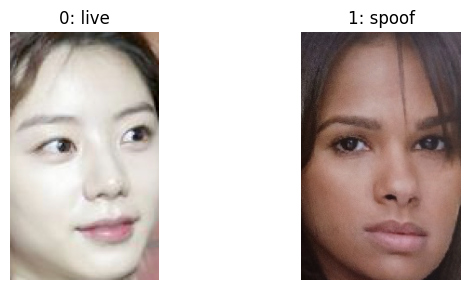

In [7]:
import numpy as np
import matplotlib.pyplot as plt

test_ds = clean_ds["test"]


# Vectorized: get all labels
labels = np.array(test_ds["labels"])

# Unique class IDs
unique_labels = np.unique(labels)

# FIRST index of each class (must cast to Python int)
first_indices = {lbl: int(np.argmax(labels == lbl)) for lbl in unique_labels}

# Plot
cols = 5
rows = (len(unique_labels) + cols - 1) // cols
plt.figure(figsize=(15, 3 * rows))

for i, lbl in enumerate(unique_labels):
    idx = first_indices[lbl]
    sample = test_ds[int(idx)]       # <— ensure int()

    img = sample["cropped_image"]
    name = sample["labelNames"]

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"{lbl}: {name}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [8]:
train_test_split = ds['test'].train_test_split(test_size=0.1)
print(len(train_test_split['test']))

6717


In [9]:
# Split the training data into train and test (let's say 10% for the test set)
train_test_split = ds['test'].train_test_split(test_size=0.1)

# Further split the training set to get a validation set (e.g., 10% of the training set)
train_val_split = train_test_split['train'].train_test_split(test_size=0.1)

# Combine the splits into a new DatasetDict
final_dataset = {
    'train': train_val_split['train'],
    'val': train_val_split['test'],
    'test': train_test_split['test']
}

final_dataset

{'train': Dataset({
     features: ['cropped_image', 'labels', 'labelNames'],
     num_rows: 54407
 }),
 'val': Dataset({
     features: ['cropped_image', 'labels', 'labelNames'],
     num_rows: 6046
 }),
 'test': Dataset({
     features: ['cropped_image', 'labels', 'labelNames'],
     num_rows: 6717
 })}

In [10]:
train_ds = final_dataset["train"]
val_ds = final_dataset["val"]
test_ds = final_dataset["test"]

Label Mapping:
Convert between label ids and their corresponding names, which is useful for model training and evaluation. **bold text**

In [11]:
id2label = {id: label for id, label in enumerate(train_ds.features["labels"].names)}
label2id = {label: id for id, label in id2label.items()}
id2label, id2label[train_ds[0]["labels"]]

({0: 'live', 1: 'spoof'}, 'spoof')

In [12]:
from transformers import ViTImageProcessor

model_name = "google/vit-large-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)
processor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [13]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    ToTensor,
    Resize,
)

# Get configurations from ViT processor
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

# Normalizes the image pixels by subtracting the mean and dividing by the std from the pretrained model configurations
normalize = Normalize(mean=image_mean, std=image_std)

# Compose: Combines a series of image transformations into one pipeline.
train_transforms = Compose(
    [
        RandomResizedCrop(size),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)
val_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)
test_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)

In [14]:
from PIL import Image
import numpy as np
count=0
count1=0
def safe_decode(img):
    if hasattr(img, "decode"):
        return img.decode()
    return img

def apply_train_transforms(examples):
    global count
    pixel_values = []
    for img in examples["cropped_image"]:

        if img is None:
            img = Image.fromarray(np.zeros((size, size, 3), dtype=np.uint8))
            count=count+1

        else:
            img = safe_decode(img)

        img = img.convert("RGB")
        pixel_values.append(val_transforms(img))

    examples["pixel_values"] = pixel_values
    return examples


def apply_val_transforms(examples):
    global count1
    pixel_values = []
    for img in examples["cropped_image"]:
        if img is None:
            img = Image.fromarray(np.zeros((size, size, 3), dtype=np.uint8))
            # print("current null validation image : ",count1)
        else:
            img = safe_decode(img)

        img = img.convert("RGB")
        pixel_values.append(val_transforms(img))

    examples["pixel_values"] = pixel_values
    return examples



def apply_test_transforms(examples):
    pixel_values = []
    for img in examples["cropped_image"]:
        if img is None:
            img = Image.fromarray(np.zeros((size, size, 3), dtype=np.uint8))
        else:
            img = safe_decode(img)

        img = img.convert("RGB")
        pixel_values.append(val_transforms(img))

    examples["pixel_values"] = pixel_values
    return examples



train_ds.set_transform(apply_train_transforms)
val_ds.set_transform(apply_val_transforms)
test_ds.set_transform(apply_test_transforms)

In [15]:
import torch
from torch.utils.data import DataLoader


def collate_fn(examples):
    # Stacks the pixel values of all examples into a single tensor and collects labels into a tensor
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["labels"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

# Create a DataLoader for the training dataset, with custom collation and a batch size of 4
train_dl = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [16]:
train_ds[0]["pixel_values"].shape


torch.Size([3, 224, 224])

In [17]:
batch = next(iter(train_dl))
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


                                    **Fine-tuning the Model**

Model creation

In [18]:
bad = []
for i in range(200):
    img = test_ds[i]["cropped_image"]
    if img is None:
        bad.append(i)

print("Bad images:", bad[:20])


Bad images: [74]


In [19]:
from transformers import ViTForImageClassification

labels  = clean_ds['test'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels = len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
from transformers import TrainingArguments, Trainer
import numpy as np

model.to("cuda")   # <--- FORCE GPU

train_args = TrainingArguments(
    output_dir="output-models",
  per_device_train_batch_size=32,
  eval_strategy="steps",
  num_train_epochs=1,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=5,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [21]:
trainer = Trainer(
    model,
    train_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    tokenizer=processor,
)
trainer.train()

/tmp/ipython-input-102844377.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
100,0.190300,0.167158
200,0.254200,0.073671
300,0.089100,0.056035
400,0.095800,0.084775
500,0.010000,0.066256
600,0.054100,0.043299
700,0.064400,0.046360
800,0.178500,0.041530
900,0.016800,0.043981
1000,0.003100,0.017624


TrainOutput(global_step=1701, training_loss=0.07048743327373569, metrics={'train_runtime': 5107.7442, 'train_samples_per_second': 10.652, 'train_steps_per_second': 0.333, 'total_flos': 1.4903936923891986e+19, 'train_loss': 0.07048743327373569, 'epoch': 1.0})

In [25]:
trainer.save_model("/content/final-vit-model")


In [27]:
!zip -r final-vit-model.zip /content/final-vit-model
from google.colab import files
files.download("final-vit-model.zip")


  adding: content/final-vit-model/ (stored 0%)
  adding: content/final-vit-model/training_args.bin (deflated 54%)
  adding: content/final-vit-model/model.safetensors (deflated 7%)
  adding: content/final-vit-model/config.json (deflated 50%)
  adding: content/final-vit-model/preprocessor_config.json (deflated 47%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
outputs = trainer.predict(test_ds)
print(outputs.metrics)

{'test_loss': 0.009817005135118961, 'test_runtime': 99.9341, 'test_samples_per_second': 67.214, 'test_steps_per_second': 8.406}


In [30]:
from transformers import ViTForImageClassification, ViTImageProcessor
from PIL import Image
import torch

# 1️⃣ Load your saved model
model = ViTForImageClassification.from_pretrained("/content/final-vit-model")
processor = ViTImageProcessor.from_pretrained("/content/final-vit-model")

# (Optional) move to GPU
model.to("cuda")
model.eval()

# 2️⃣ Load your test image
image = Image.open("/content/picture .jpg")

# 3️⃣ Preprocess
inputs = processor(images=image, return_tensors="pt").to("cuda")

# 4️⃣ Inference
with torch.no_grad():
    outputs = model(**inputs)

# 5️⃣ Prediction
pred = outputs.logits.argmax(-1).item()

# 6️⃣ Output label
print("Predicted label:", model.config.id2label[pred])


Predicted label: live


In [31]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Get predictions
outputs = trainer.predict(test_ds)

# Get predicted class indices
y_pred = np.argmax(outputs.predictions, axis=1)

# True labels
y_true = outputs.label_ids


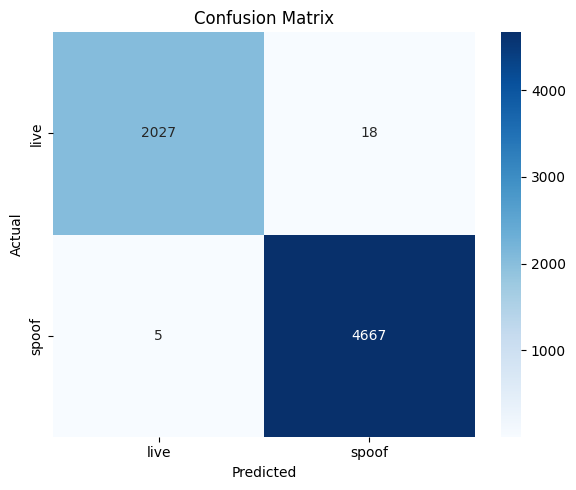

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")  # save as PNG
plt.show()
